# 波士顿房价数据集

该数据集用于回归问题。

波士顿房价数据集较小，只有 506 个数据点，分为 404 个训练样本和 102 个测试样本。输入数据的每个特征都有不同的取值范围。例如，有些特性是比例，取值范围 0~1；有些取值范围为 1~12；还有的取值范围为 0~100，等等。

In [1]:
from tensorflow.keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57344/57026 [==============================] - 0s 2us/step


In [3]:
train_data.shape

(404, 13)

In [4]:
test_data.shape

(102, 13)

每个样本都有 13 个数值特征，比如人均犯罪率、每个住宅的平均房间数、高速公路可达性等。

目标是房屋价格的中位数，单位是千美元。

In [5]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

房价大多在 10,000~50,000 美元。

## 准备数据

去取值范围差异较大的数据，最好对每个特征做标准化，即对于输入数据的每个特征，减去特征平均值，再除以标准差，这样得到的特征值平均值为 0，标准差为 1.

In [6]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

注意，用于测试数据标准化的均值和标准差都是在训练数据上计算得到的。在工作流程中，你不能使用在测试数据上得到的任何结果，即使是像标准化这么简单的事情也不行。

## 构建网络

由于样本量很少，我们使用一个非常小的网络，其中包含两个隐藏层，每层有 64 个单元。一般来说，训练数据越小，过拟合会越严重，而较小的网络可以降低过拟合。

In [8]:
from tensorflow.keras import models
from tensorflow.keras import layers

def build_model():
    """
    因为需要多次实例化该模型，因此用函数构建模型
    """
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

    return model


网络的最后一层只有一个单元，没有激活，只是一个线性层。这是标量回归的典型设置。添加激活函数将会限制输出范围。例如，如果向最后一层添加 sigmoid 激活函数，网络智能学会预测 0~1 范围内的值。这里最后一层是纯线性的，所以网络可以学会预测任意范围内的值。

编译网络用的 MSE 损失函数，即均方误差（MSE, mean squared error），预测值与目标值之间的平方。这是回归问题常用的损失函数。

在训练过程中还监控一个新指标：平均绝对误差（MAE, mean absolute error），它是预测值与目标值之间的绝对值。比如，如果这个问题的 MAE 等于 0.5，表示你预测的放假与实际价格平均相差 500 美元。

## 利用 K 折验证

为了在调节网络参数的同时对网络进行评估，可以将数据划分为训练集和验证集，正如前面例子中所做。但由于数据点很少，验证集会非常小（比如只有 100 个样本）。因此，验证分数可能会有很大的波动，这取决于你所选择的验证集和训练集。即，验证集的划分方式可能会造成验证分数上有很大的方差，这样就无法对模型进行可靠的评估。

在这种情况下，最佳做法是使用 K 折交叉验证。这种方法将数据划分为 K 个分区（K 通常取 4 或 5），实例化 K 个相同的模型，将每个模型在 K-1 个分区上训练，并在剩下的一个分区上进行评估。模型的验证分数等于 K 个验证分数的平均值。

In [11]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('processing fold #', i)
    # 准备验证数据，第 k 个分区的数据
    val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i+1)*num_val_samples]

    # 准备训练数据，其它所有分区的数据
    partial_train_data = np.concatenate([train_data[:i*num_val_samples],
                                        train_data[(i+1) * num_val_samples:]],axis=0)
    partial_train_targets = np.concatenate([train_targets[:i* num_val_samples],
                                        train_targets[(i+1)*num_val_samples:]], axis=0)
    model = build_model()
    model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)


processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [12]:
all_scores

[2.0536139011383057, 2.576986789703369, 2.576010227203369, 2.644355297088623]

In [13]:
np.mean(all_scores)

2.4627415537834167

误差在 2500 美元，考虑到实际价格范围在 10,000~50,000 美元，这个差别还是很大的。

我们让训练时间更长一点，达到 500 个轮次。

In [17]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(    
        [train_data[:i * num_val_samples], 
         train_data[(i + 1) * num_val_samples:]],  
        axis=0) 
    partial_train_targets = np.concatenate( 
        [train_targets[:i * num_val_samples], 
         train_targets[(i + 1) * num_val_samples:]], 
        axis=0) 
    model = build_model()   
    history = model.fit(partial_train_data, partial_train_targets,   
                        validation_data=(val_data, val_targets), 
                        epochs=num_epochs, batch_size=1, verbose=0) 
    mae_history = history.history['val_mae'] 
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [18]:
# 然后计算每个轮次中所有折 MAE 的平均值

average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

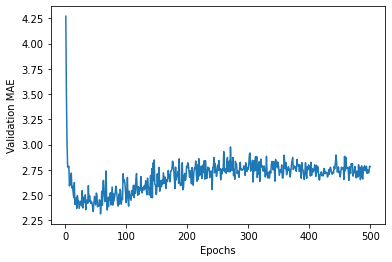

In [19]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()